In [1]:
from torch.utils.data import DataLoader

from faim_dl.data_record import DefaultDataRecord
from faim_dl.dataset import ZarrDataset

import gunpowder as gp

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

import math
import numpy as np

In [2]:
datarecord = DefaultDataRecord.deserialize('./dataset/BBBC039.zarr/BBBC039_rdf.json')

In [3]:
datarecord.attachments

{'train_data': {'data': './train_data', 'histogram': './train_data_hist.npz'},
 'val_data': {'data': './val_data', 'histogram': './val_data_hist.npz'},
 'test_data': {'data': './test_data', 'histogram': './test_data_hist.npz'}}

In [4]:
train_hist = datarecord.histograms['train_data']
ds = ZarrDataset('./dataset/BBBC039.zarr', 
                 dataset_name='train_data', 
                 target_name='nuclei',
                 random_location=True,
                 simple_augment=True,
                 elastic_augment={"control_point_spacing": (16, 16),
                                  "jitter_sigma": (1.5, 1.5),
                                  "rotation_interval": (0, math.pi / 2),
                                  "scale_interval": (0.9, 1.1)},
                 intensity_augment={"scale_min": 0.9,
                                    "scale_max": 1.1,
                                    "shift_min": -0.1,
                                    "shift_max": 0.1},
                 noise_augment={"mean": 0, "min_var": 0.05, "max_var": 0.001},
                 shape=(64, 64),
                 normalization_mi_ma=(train_hist.quantile(0.03), train_hist.quantile(0.998)))

In [5]:
colors = np.random.rand(255, 4)
colors[0] = 0
colors[0,-1] = 1
label_cmap = ListedColormap(colors)

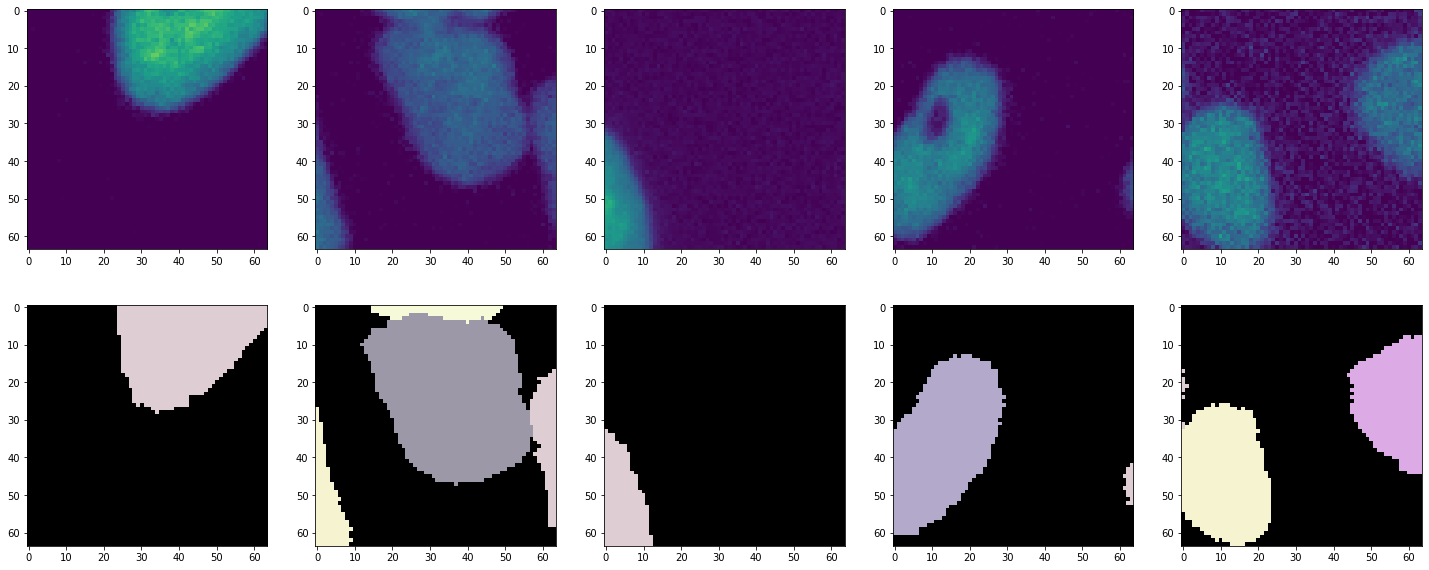

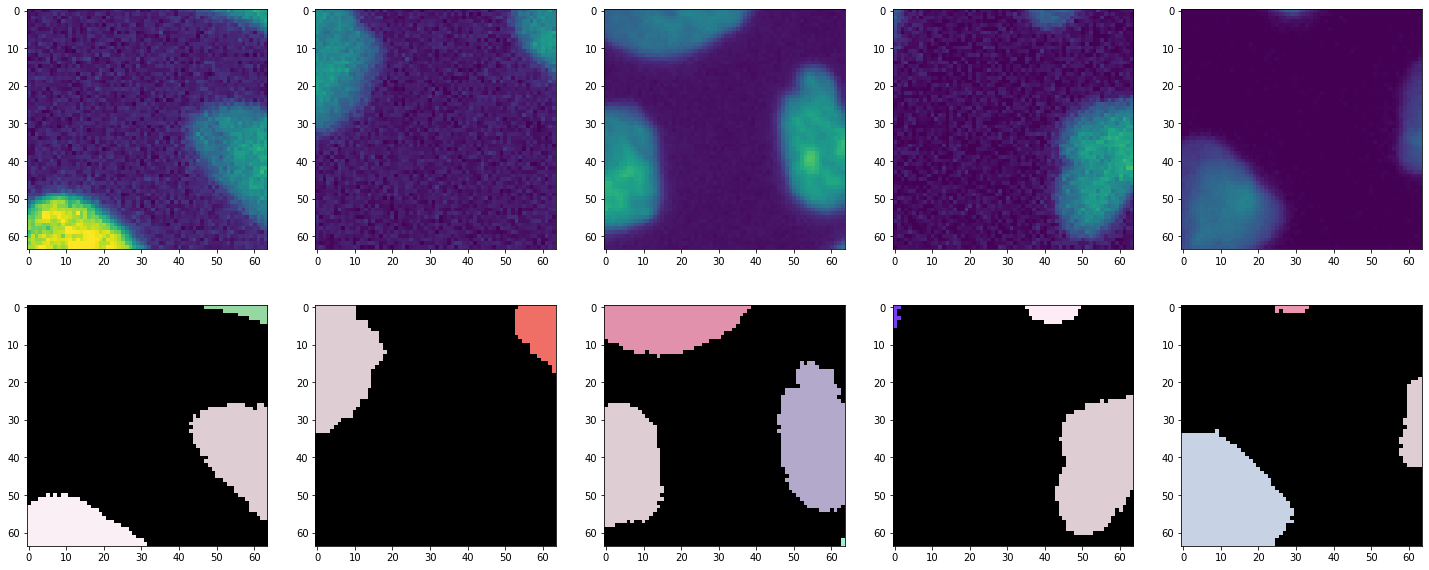

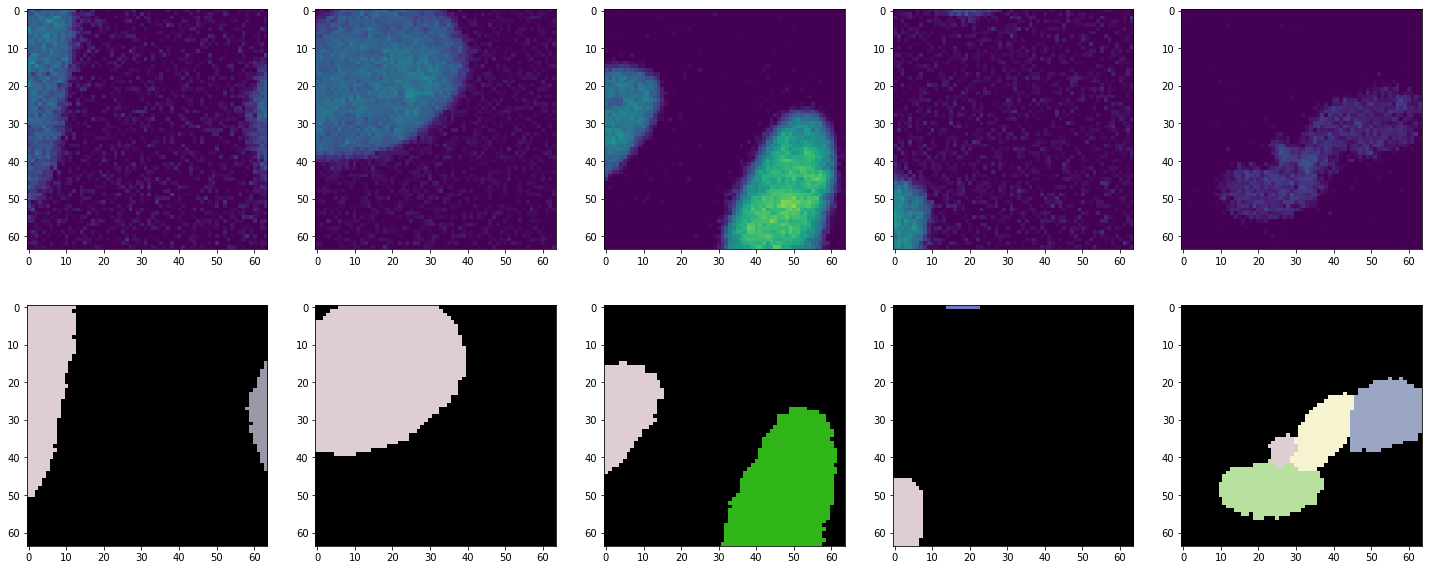

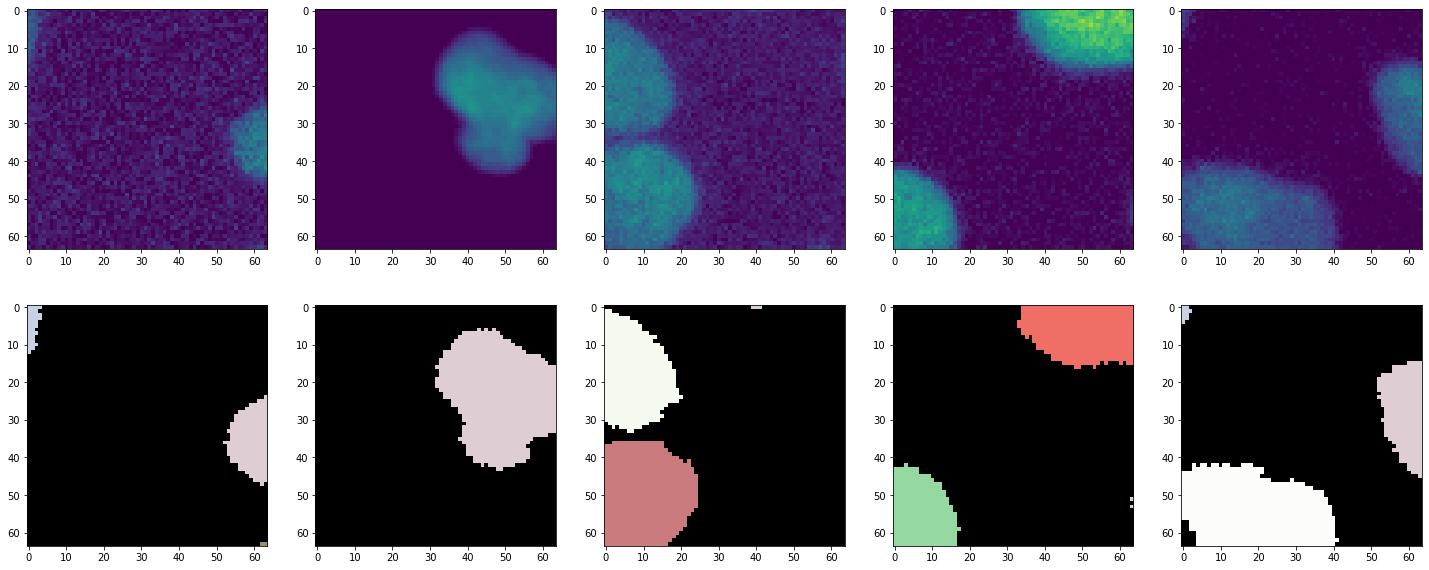

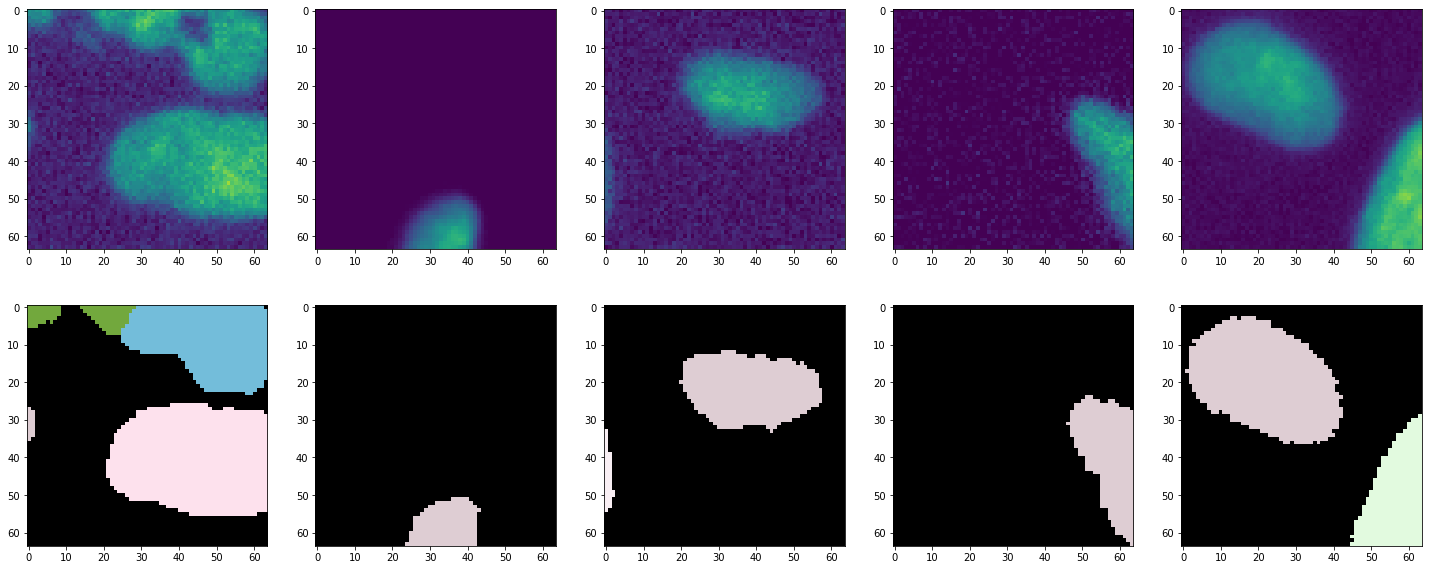

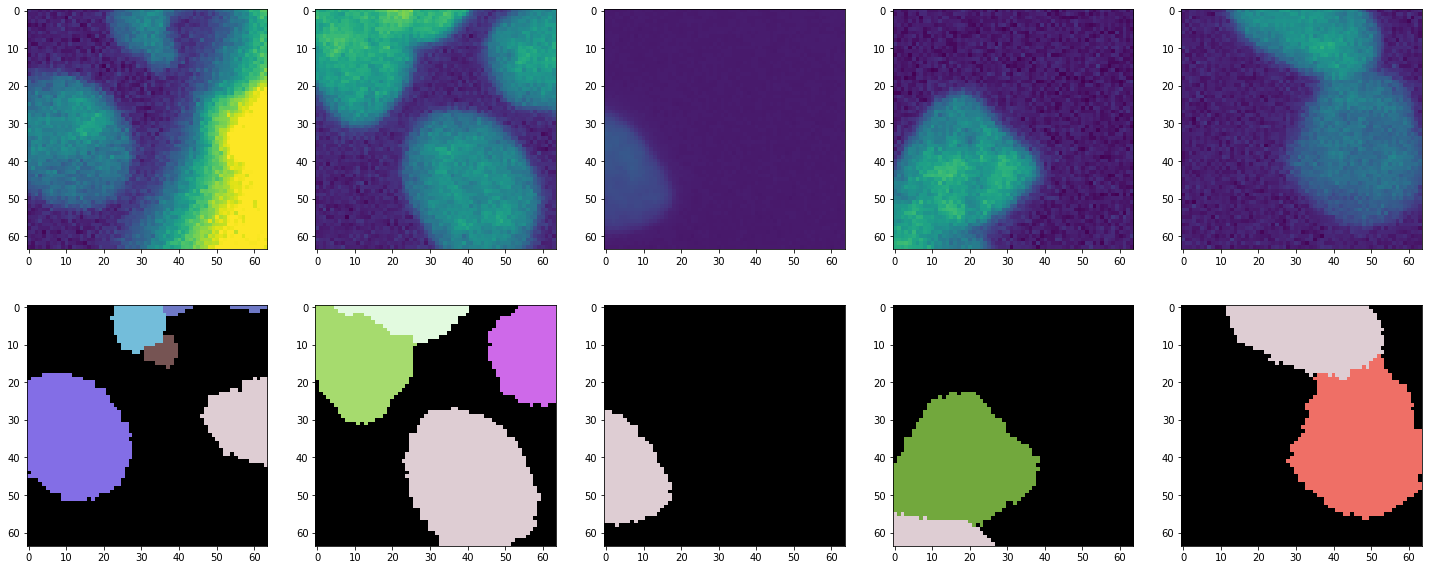

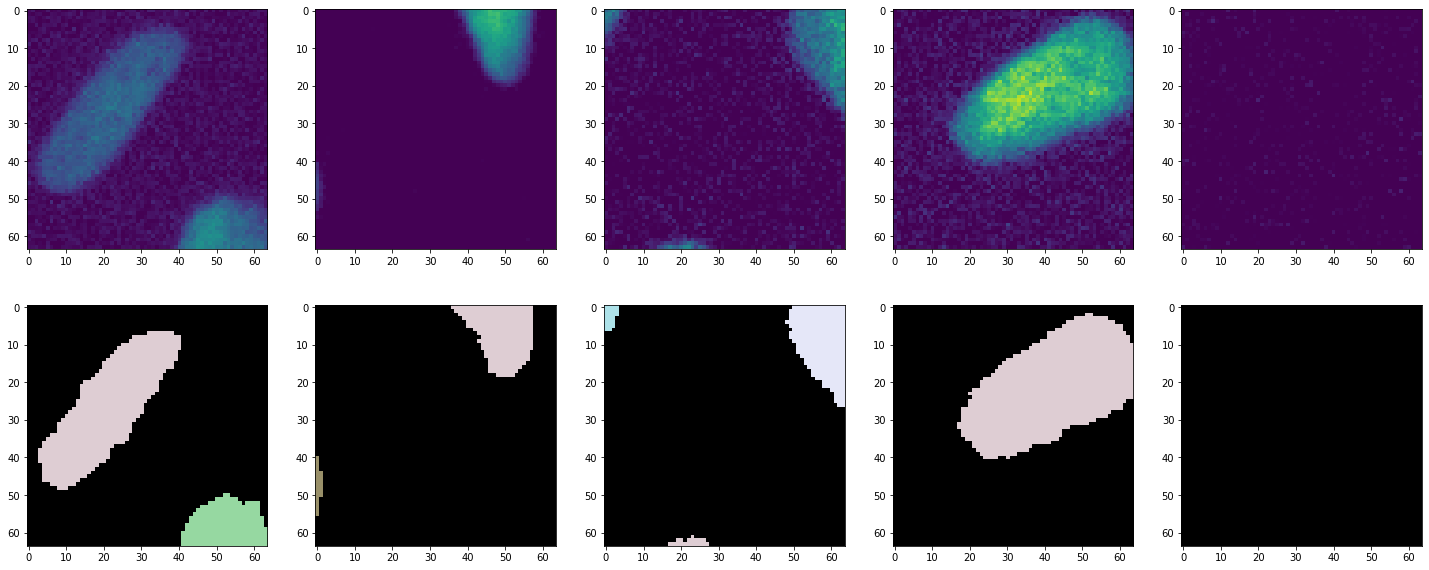

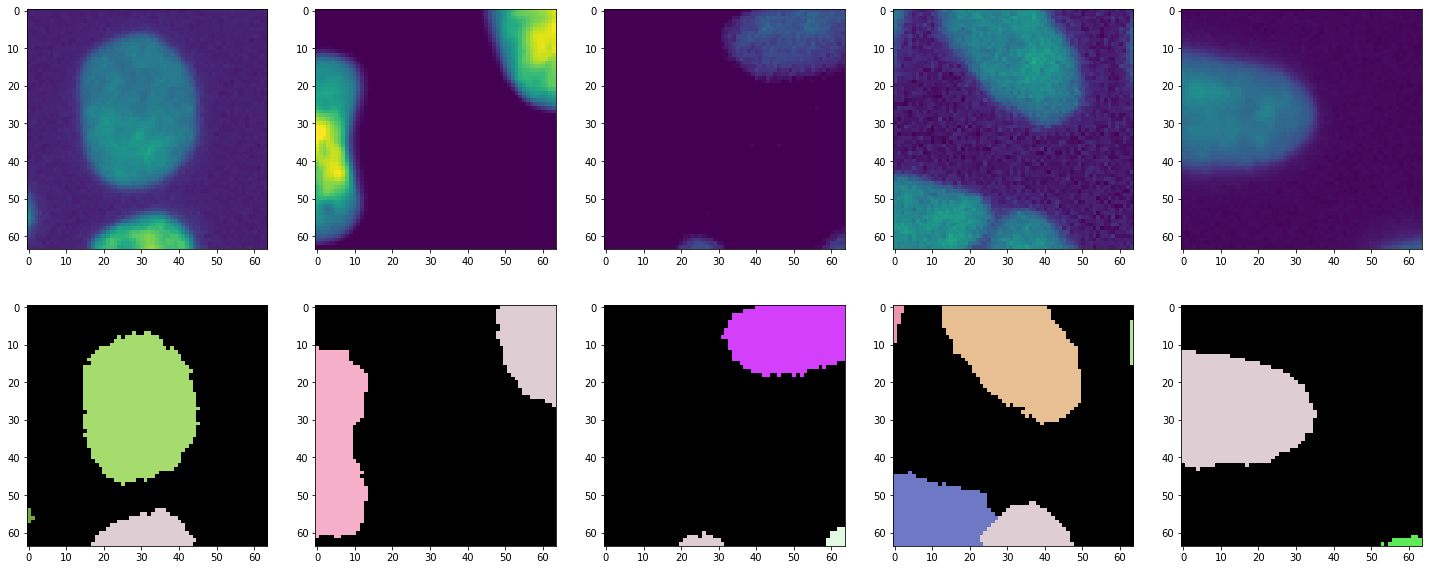

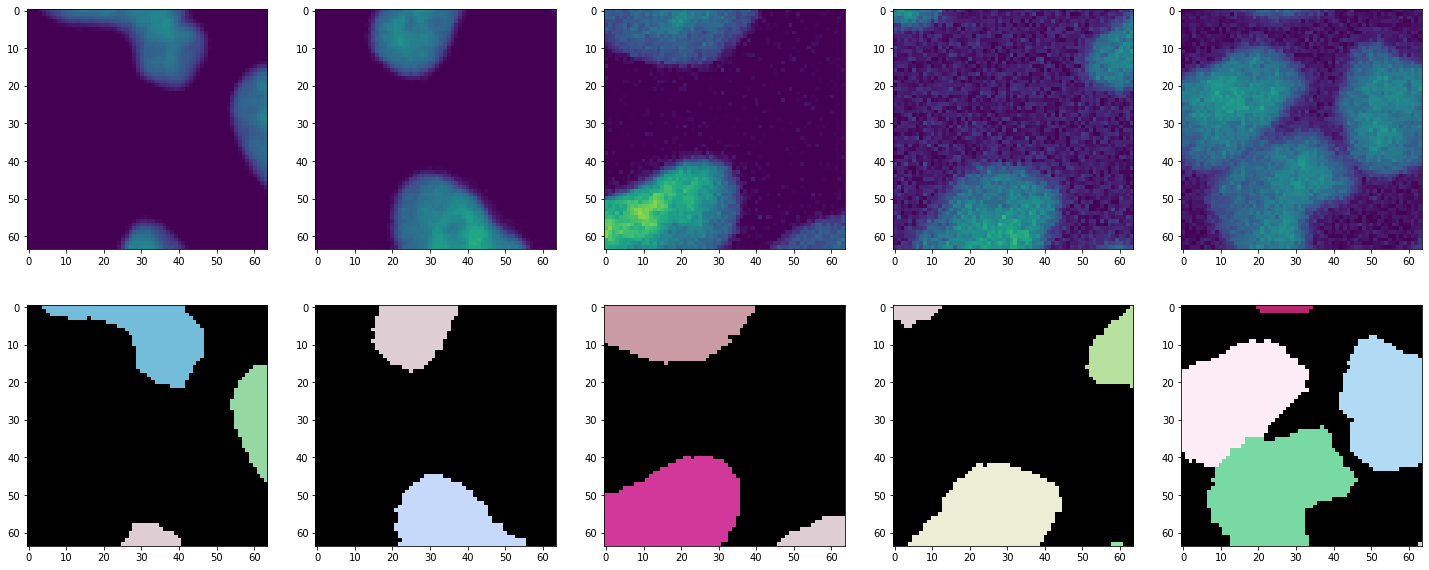

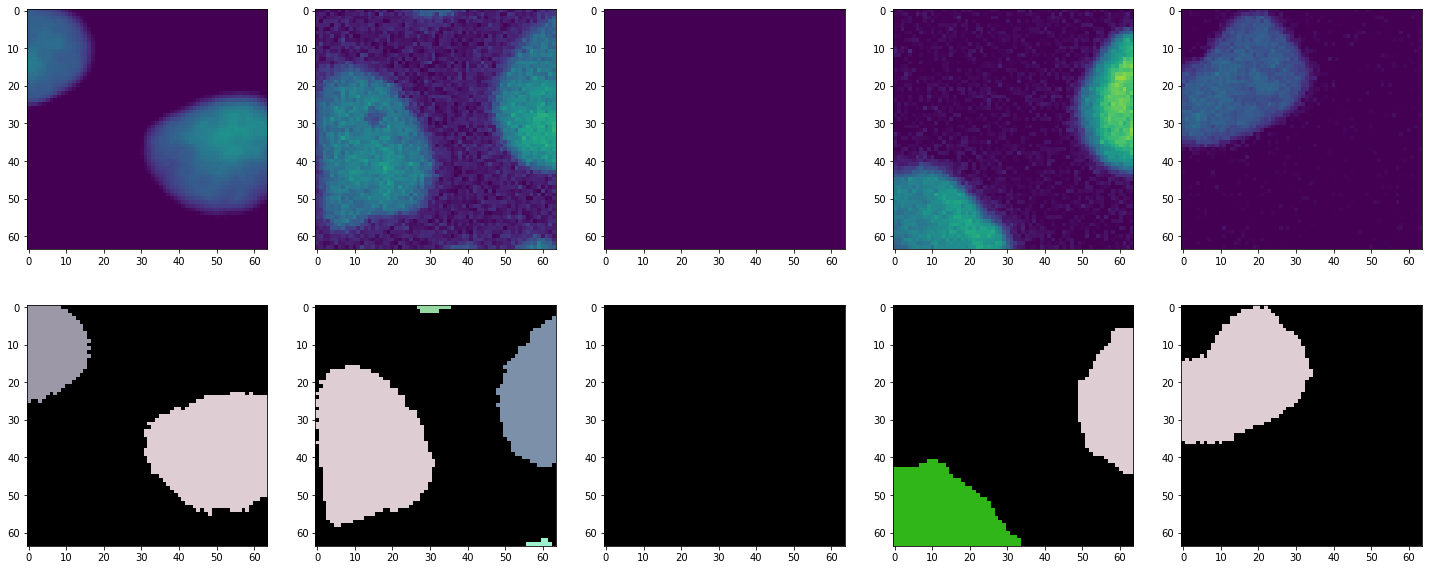

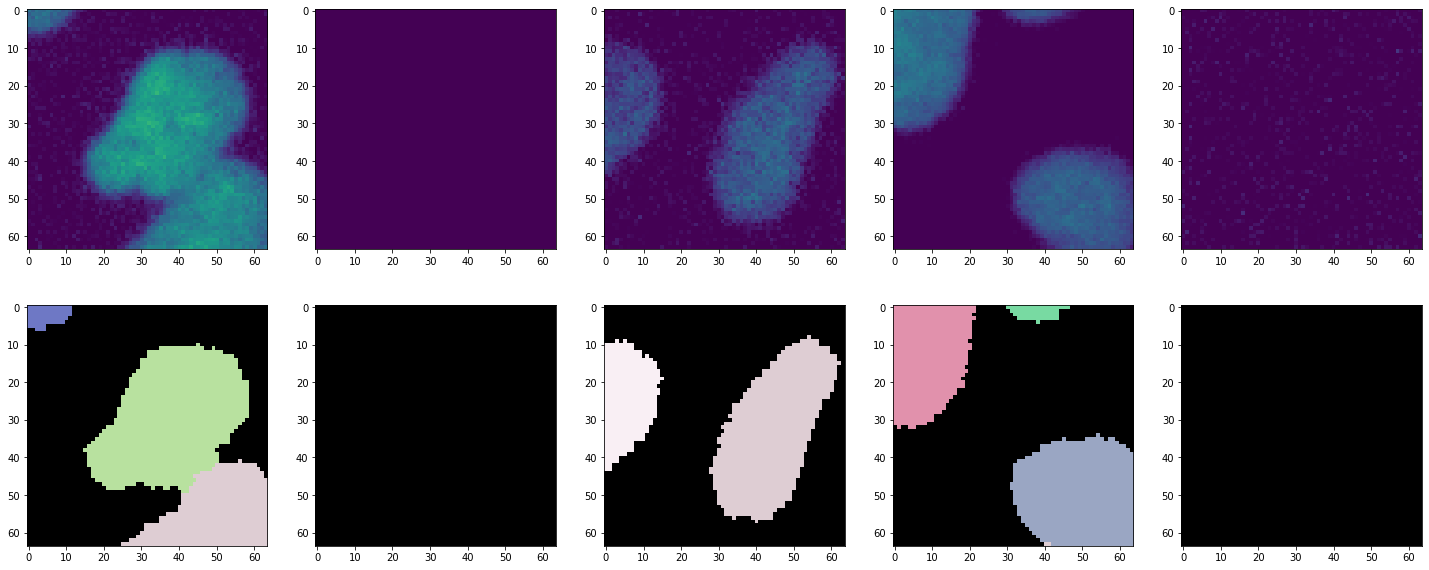

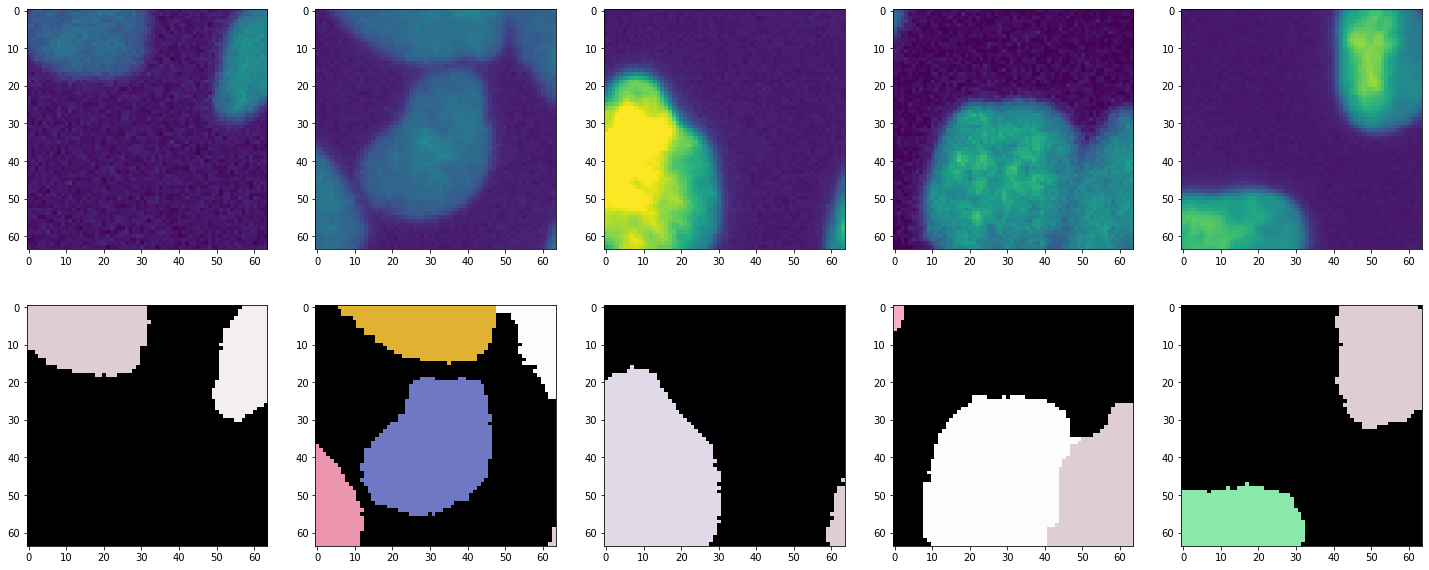

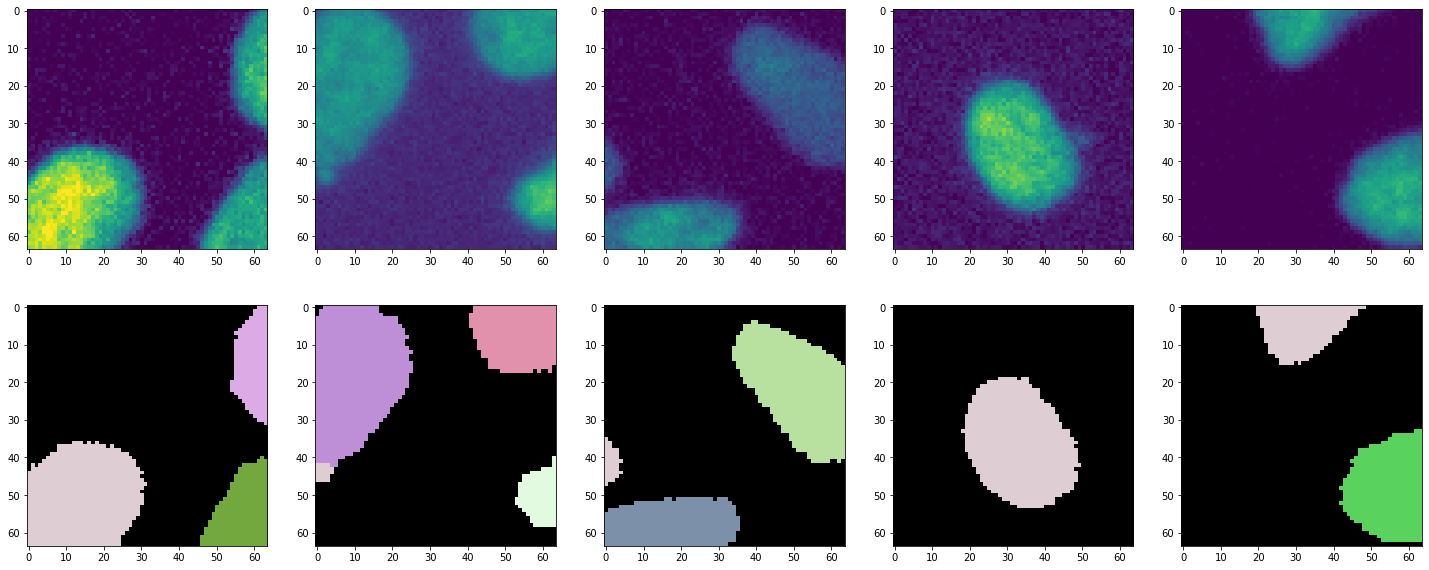

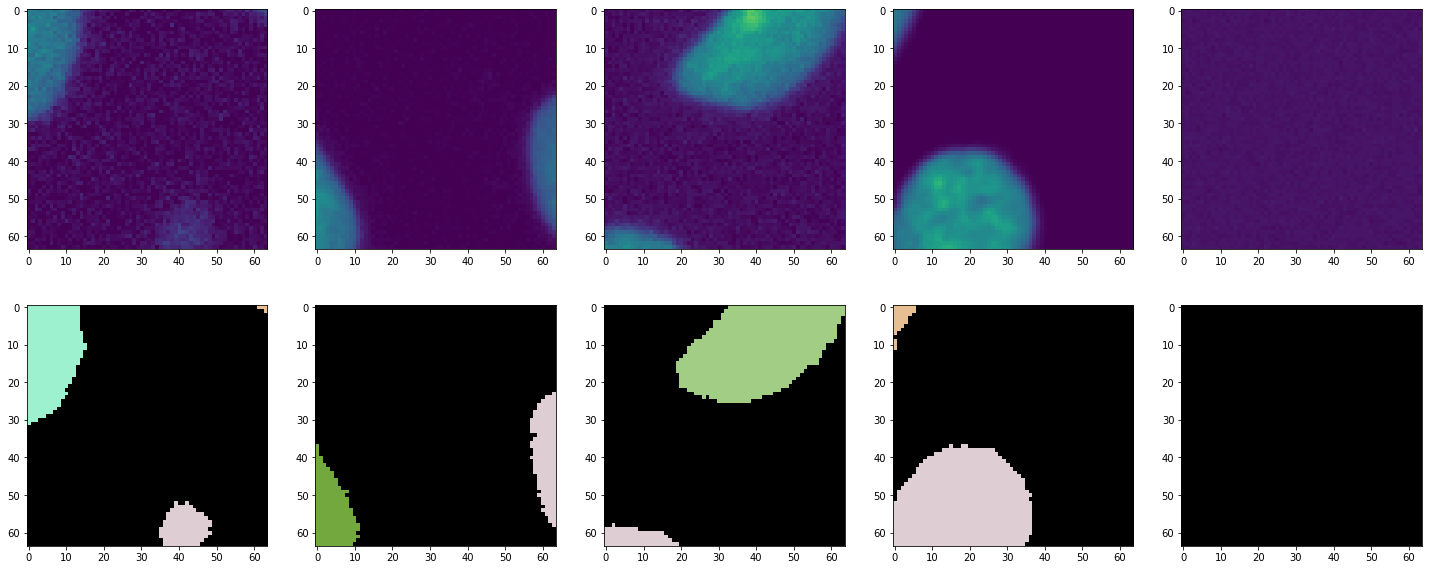

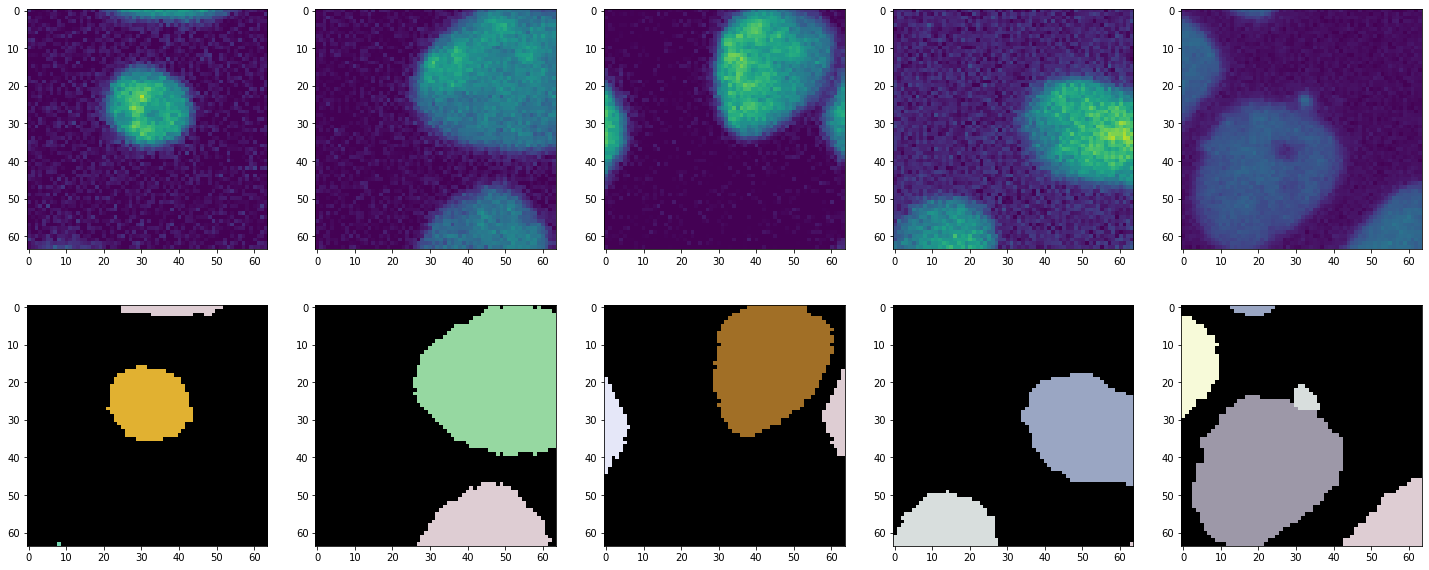

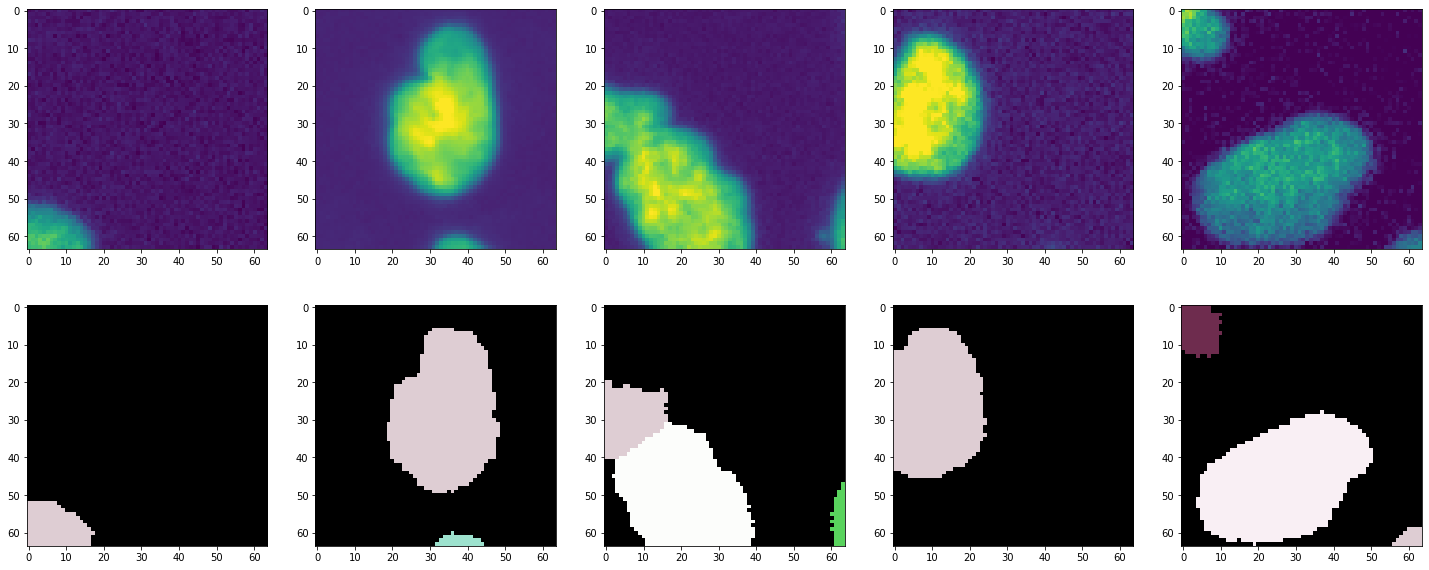

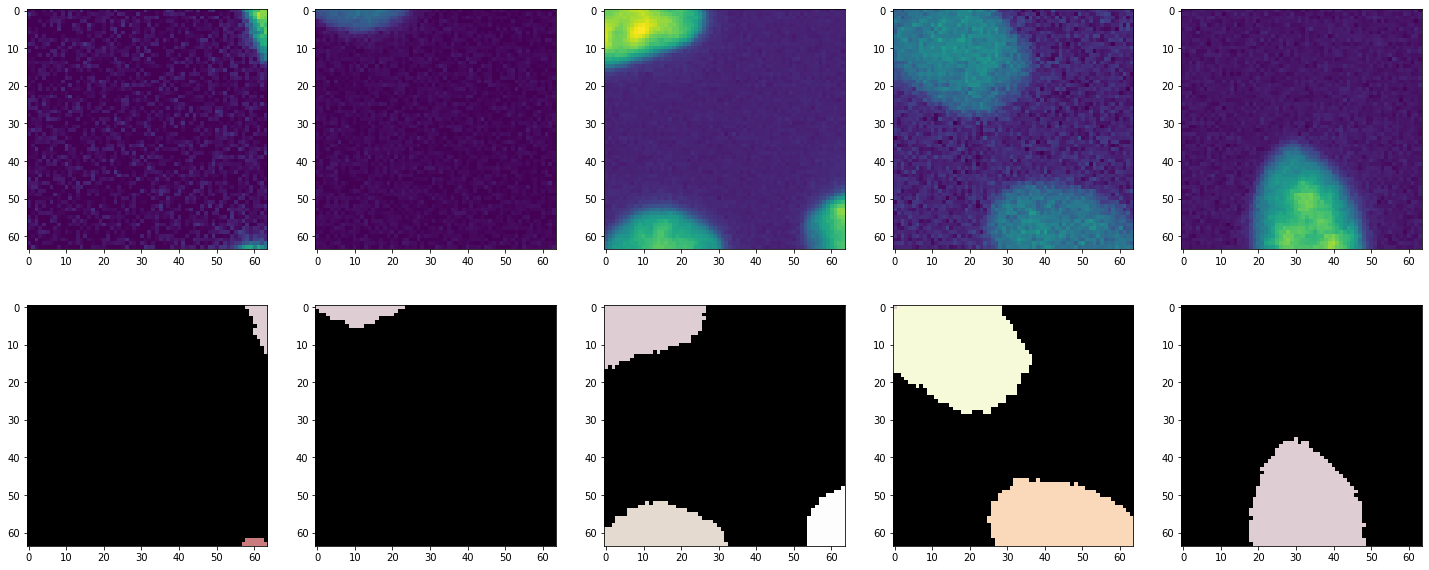

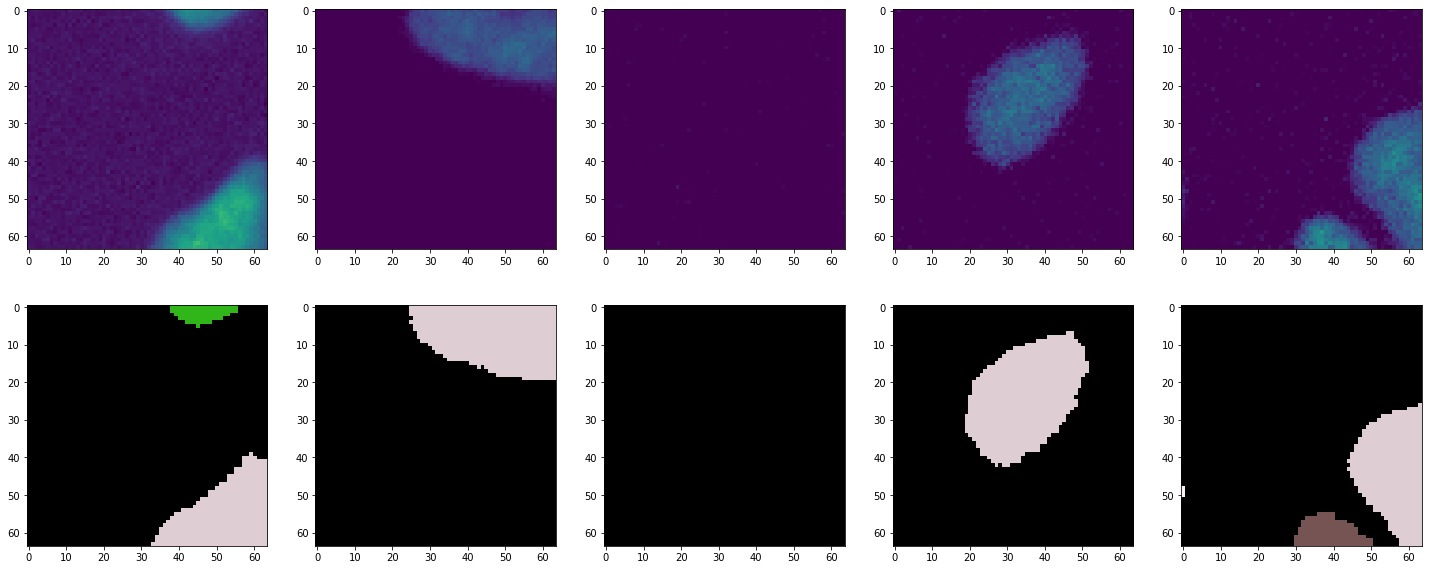

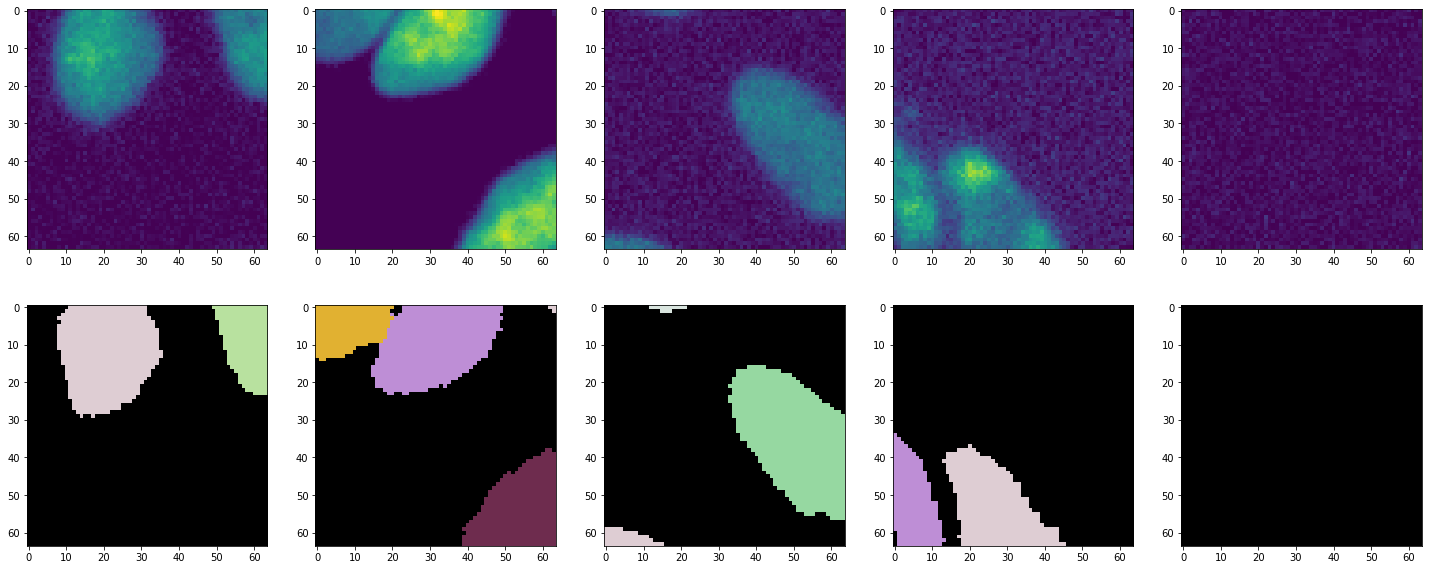

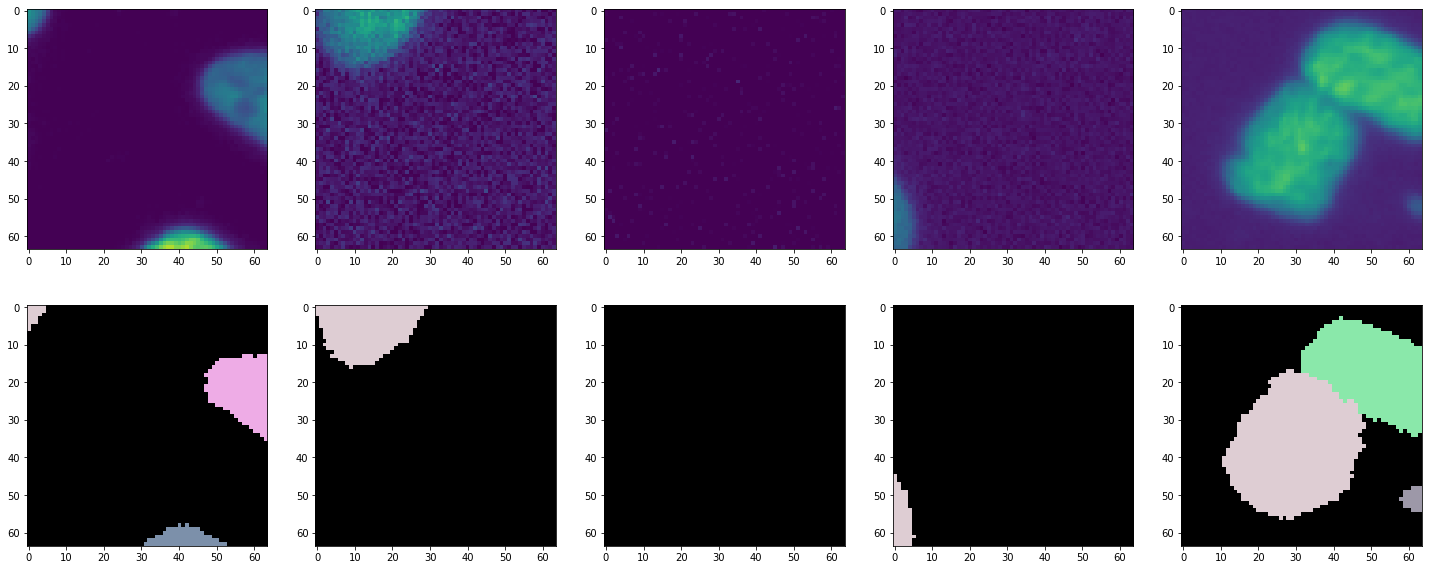

In [6]:
dl = DataLoader(ds, batch_size=5)
for batch in dl:
    plt.figure(figsize=(25,10))
    plt.subplot(2,5,1)
    plt.imshow(batch[0][0,...,0], vmin=0, vmax=1)
    plt.subplot(2,5,2)
    plt.imshow(batch[0][1,...,0], vmin=0, vmax=1)
    plt.subplot(2,5,3)
    plt.imshow(batch[0][2,...,0], vmin=0, vmax=1)
    plt.subplot(2,5,4)
    plt.imshow(batch[0][3,...,0], vmin=0, vmax=1)
    plt.subplot(2,5,5)
    plt.imshow(batch[0][4,...,0], vmin=0, vmax=1)
    plt.subplot(2,5,6)
    plt.imshow(batch[1][0,...,0], cmap=label_cmap, interpolation='nearest')
    plt.subplot(2,5,7)
    plt.imshow(batch[1][1,...,0], cmap=label_cmap, interpolation='nearest')
    plt.subplot(2,5,8)
    plt.imshow(batch[1][2,...,0], cmap=label_cmap, interpolation='nearest')
    plt.subplot(2,5,9)
    plt.imshow(batch[1][3,...,0], cmap=label_cmap, interpolation='nearest')
    plt.subplot(2,5,10)
    plt.imshow(batch[1][4,...,0], cmap=label_cmap, interpolation='nearest')
    plt.show()